# PINN-MPC:

This notebook implements the **PINN-MPC** framework, presented in: *"An Explicit Model Predictive Control Framework Based On Physics-Informed Neural Networks"* by Kardamaki et al., for a single-input-single-output (SISO) nonlinear water tank system. The controller is trained as a feedforward neural network using a composite loss function that enforces the governing differential equations while incorporating control-oriented objectives such as set-point tracking, control smoothness, and soft constraints on states, inputs, and outputs.

This notebook is organized into sections for:
- Training the PINN-MPC using the composite loss function,
- Validating its performance on set-point tracking and disturbance rejection scenarios and inspecting plot results for closed-loop performance

All training hyperparameters, including the weights of the loss function and the settings of the optimizers, along with simulation parameters can be customized to explore different control configurations.

**Case Study Description:**

The tank receives inflow through a controllable source and a measured disturbance, modeled as an additive inflow perturbation. The evolution of the water level is described by the following first-order nonlinear ODE:

$$ \dot{x}(t) = \frac{1}{A} \left( u(t) +d(t) - K \sqrt{x(t)} \right) $$
$$ {y}(t) = {x}(t) $$

where:

* $x(t)=y(t) \geq 0$ is the water level in the tank $(\mathrm{m})$,
* $u(t)$ is the inflow rate $(\mathrm{m}^3/\mathrm{s})$,
* $d(t)$ is the measured inflow disturbance $(\mathrm{m}^3/\mathrm{s})$,
* $A = 1.0$ is the tank’s cross-sectional area $(\mathrm{m}^2)$,
* $K = 0.7$ is the outflow coefficient $(\mathrm{m}^{2.5}/\mathrm{s})$.


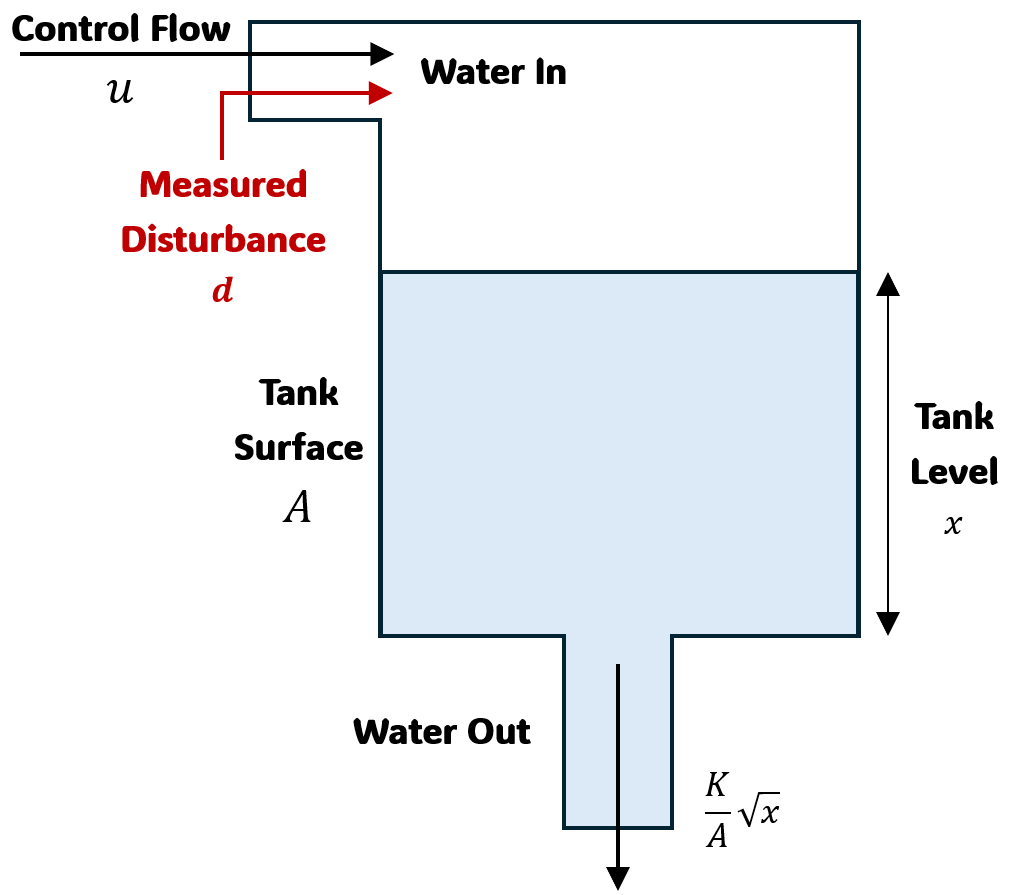

## Preliminaries

**Import Libraries**

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

from __future__ import annotations
import argparse
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
from itertools import product
import itertools
import matplotlib.cm as cm
from typing import Sequence, Union
from matplotlib.ticker import MultipleLocator
from typing import List
from datetime import datetime
from matplotlib.lines import Line2D
from statistics import mean

**Select Device**

In [ ]:
## ---------------------------- SELECT DEVICE ------------------------------- ##

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA GPU found")

CUDA available: True
CUDA device count: 1
Device name: NVIDIA GeForce RTX 3060 Ti


## Open-Loop

--- Simulation Results ---
Theoretical steady-state: 2.041 m
Settling time: 17.53s


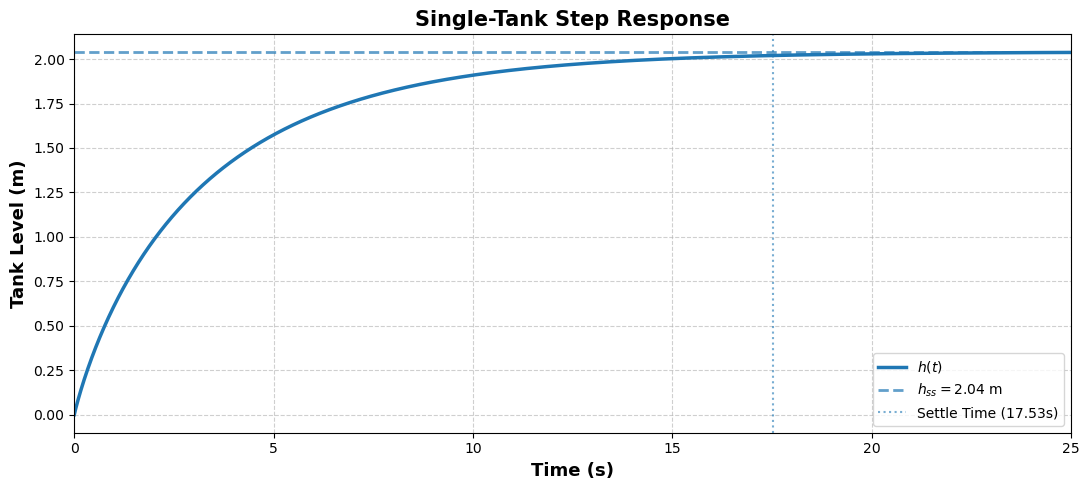

In [ ]:
"""

Single-Tank Process Simulator
This script simulates the dynamics of a nonlinear single water tank.

"""

# ---------- Open-loop step simulation (Euler) ----------

def simulate_tank_step_response(
    y_init: float = 0.0,
    u: float = 1.0,
    K_VALVE: float = 0.7,
    A: float = 1.0,
    dt: float = 0.01,
    simulation_time: float = 25.0,
    d: float = 0.0,
    tol: float = 0.01
) -> tuple:
    """
    Args:
        y_init: Initial tank level (m).
        u: Step inflow rate (m³/s).
        K_VALVE: Outflow coefficient (m².⁵/s).
        A: Tank cross-sectional area (m²).
        dt: Time step for numerical integration (s).
        simulation_time: Total simulation duration (s).
        d: Constant disturbance flow (m³/s).
        tol: Relative tolerance for settling band (as fraction of y_ss).
    Returns:
        A tuple containing:
        - t_hist (np.ndarray): (N+1,) array of time stamps.
        - y_hist (np.ndarray): (N+1,) array of tank level history.
        - u_hist (np.ndarray): (N+1,) array of inflow history.
        - settled_time (float or None): Time when steady-state is reached (s),
                                        or None if not settled.
        - y_ss (float): Theoretical steady-state level (m).
    """
    steps = int(simulation_time / dt)
    y = y_init

    # Pre-calculate the theoretical steady-state
    y_ss = ((u + d) / K_VALVE)**2 if K_VALVE > 0 else 0.0

    # Initialize history lists
    t_hist = [0.0]
    y_hist = [y_init]
    u_hist = [u]

    t_curr = 0.0
    settled_time = None
    settle_buffer = [] # Stores timestamps of in-band points

    # The state needs to be in-band for 1.0 second to be "settled"
    inband_pts_needed = int(max(1, round(1.0 / dt)))

    # --- Simulation loop ---
    for _ in range(steps):
        # Compute tank level dynamics (Euler step)
        dy = (u + d - K_VALVE * math.sqrt(max(y, 0.0))) / A
        y = max(y + dy * dt, 0.0) # Apply step and clamp at zero
        t_curr += dt

        # Store simulation data
        t_hist.append(t_curr)
        y_hist.append(y)
        u_hist.append(u)

        # --- Check for settling ---
        # Define the tolerance band (relative to steady-state value)
        band = tol * max(1e-12, y_ss)

        if abs(y - y_ss) <= band:
            # Point is inside the tolerance band
            settle_buffer.append(t_curr)

            # If tank isn't already marked as settled and buffer is full
            if settled_time is None and len(settle_buffer) >= inband_pts_needed:
                # Mark as settled, using the *first* timestamp in the buffer
                settled_time = settle_buffer[0]
        else:
            # Point is outside the band, reset the buffer
            settle_buffer.clear()

    return (
        np.array(t_hist, dtype=float),
        np.array(y_hist, dtype=float),
        np.array(u_hist, dtype=float),
        settled_time,
        y_ss
    )

# ---------------- Demo ----------------
if __name__ == "__main__":
    # --- Run Simulation ---
    t, y, u, settle_time, y_ss = simulate_tank_step_response(
        dt=0.01,
        d=0.0,
        simulation_time=25.0,
        tol=0.01
    )

    # --- Print results ---
    print("--- Simulation Results ---")
    print(f"Theoretical steady-state: {y_ss:.3f} m")
    st_print = f"{settle_time:.2f}s" if settle_time is not None else "Not Settled"
    print(f"Settling time: {st_print}")

    # --- Plot Results ---
    plt.figure(figsize=(11, 5))
    plt.title("Single-Tank Step Response", fontsize=15, fontweight="bold")
    colors = plt.get_cmap('tab10')
    color_y = colors(0)

    # Plot tank level
    plt.plot(t, y, linewidth=2.5, label=r'$y(t)$', color=color_y)
    # Plot steady-state horizontal line
    plt.axhline(y_ss, linestyle="--", linewidth=2, color=color_y, alpha=0.7,
                label=fr'$y_{{ss}} = {y_ss:.2f}$ m')
    # Plot vertical settling time line
    if settle_time is not None:
        plt.axvline(settle_time, linestyle=":", alpha=0.6, color=color_y,
                    label=f"Settle Time ({settle_time:.2f}s)")

    plt.xlabel("Time (s)", fontsize=13, fontweight="bold")
    plt.ylabel("Tank Level (m)", fontsize=13, fontweight="bold")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.xlim(t[0], t[-1])
    plt.tight_layout()
    plt.show()

## PINN-MPC Training

### Auxiliary Functions

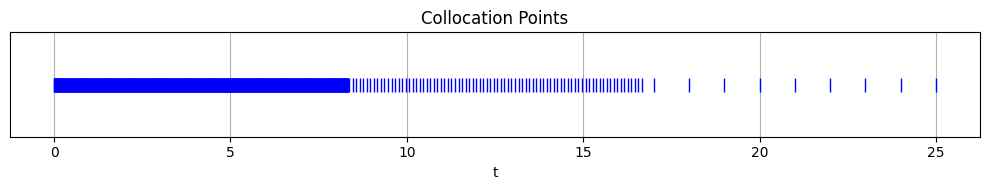

In [4]:
## ------- GENERATE NON-UNIFORM COLLOCATION POINTS OVER TIME HORIZON -------- ##

def generate_collocation_points(horizon: float,
                                dt_dense: float = 0.01,
                                dt_medium: float = 0.05,
                                dt_sparse: float = 0.1) -> torch.Tensor:
    """
    Generates collocation points over a time horizon with non-uniform density,
    dividing the timeline into three regions with sparse sampling, medium
    sampling and dense sampling.
    Args:
        horizon (float): Total time horizon (s).
        dt_dense (float): Time step for dense region near t = 0.
        dt_medium (float): Time step for medium region.
        dt_sparse (float): Time step for sparse region near t = horizon.
    Returns:
        t_col (torch.Tensor): 1D tensor of sorted collocation points on (0, horizon].
    """
    # Define region boundaries (breakpoints)
    t_break1 = 2 * horizon / 3  # End of sparse region (from horizon)
    t_break2 = 1 * horizon / 3  # End of medium region (from t_break1)

    # Sparse region: [horizon, ..., t_break1 + dt_sparse]
    t_back_sparse = torch.arange(horizon, t_break1, -dt_sparse, device=DEVICE)
    # Medium region: [t_break1, ..., t_break2 + dt_medium]
    t_back_medium = torch.arange(t_break1, t_break2, -dt_medium, device=DEVICE)
    # Dense region: [t_break2, ..., 0 + dt_dense]
    t_back_dense = torch.arange(t_break2, 0.0, -dt_dense, device=DEVICE)
    # Concatenate all points
    t_col = torch.cat([
        t_back_sparse,
        t_back_medium,
        t_back_dense,
        torch.tensor([horizon], device=DEVICE)
    ])

    # Process the collected points
    t_col = torch.unique(t_col)      # Remove duplicates
    t_col = torch.sort(t_col).values # Sort ascending
    if t_col[-1] < horizon:
        t_col = torch.cat([t_col, torch.tensor([horizon], device=DEVICE)])
    if t_col[0] > 0:
        t_col = torch.cat([torch.tensor([0.0], device=DEVICE), t_col])

    return t_col

# -------------------------------- Demo ---------------------------------------#
# Generate the points
t_col = generate_collocation_points(
    horizon=25.0,
    dt_dense=0.01,
    dt_medium=0.1,
    dt_sparse=1.0
)

# Visualize collocation points
plt.figure(figsize=(10, 2))
plt.plot(t_col.cpu().numpy(),torch.zeros_like(t_col).cpu().numpy(),'|b', markersize=10)
plt.title("Collocation Points")
plt.xlabel("t"); plt.yticks([])
plt.grid(True); plt.tight_layout(); plt.show()

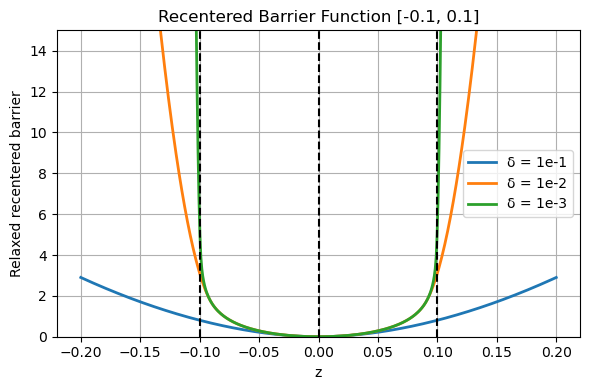

In [ ]:
## --------- RELAXED RECENTERED BARRIER FUNCTION FOR Δu CONSTRAINTS --------- ##

def barrier_du(z, z_min, z_max, delta):
    """
    Computes a relaxed, recentered barrier penalty to softly enforce:
        z_min <= z <= z_max

    This function is used in the study to apply smooth penalties on Δu, discouraging
    violations of specified bounds using a differentiable approximation.
    Args:
        z (Tensor): Quantity to penalize (can be scalar or tensor).
        z_min (float): Lower bound.
        z_max (float): Upper bound.
        delta (float): Positive relaxation parameter (controls smoothness near boundaries).
    Returns:
        B_rec (Tensor): Relaxed and recentered barrier penalty.
    """
    # Convert bounds and delta to tensors matching z's device and dtype
    z_min_t = torch.tensor(z_min, device=z.device, dtype=z.dtype)
    z_max_t = torch.tensor(z_max, device=z.device, dtype=z.dtype)
    delta_t = torch.tensor(delta, device=z.device, dtype=z.dtype)

    def B_single(x, delta):
        """
        Relaxed single-sided barrier.
        For x > delta:      -log(x)
        For x <= delta:     quadratic smoothing
        """
        return torch.where(
            x > delta,
            -torch.log(x),
            0.5 * ((x - 2 * delta) / delta) ** 2 - 0.5 - torch.log(delta)
        )

    # Apply single-sided barrier to both bounds
    B_raw = B_single(z - z_min_t, delta_t) + B_single(z_max_t - z, delta_t)

    # Recenter barrier so minimum penalty is zero (at midpoint)
    z_c = 0.5 * (z_min_t + z_max_t)
    B_center = B_single(z_c - z_min_t, delta_t) + B_single(z_max_t - z_c, delta_t)
    B_rec = B_raw - B_center

    return B_rec

# -------------------------------- Demo ---------------------------------------#
z_min, z_max = -0.1, 0.1
z = torch.linspace(-0.2, 0.2, 500)

B_1 = barrier_du(z, z_min, z_max, 1e-1)
B_2 = barrier_du(z, z_min, z_max, 1e-2)
B_3 = barrier_du(z, z_min, z_max, 1e-3)

plt.figure(figsize=(6, 4))
plt.plot(z.numpy(), B_1.numpy(), lw=2)
plt.plot(z.numpy(), B_2.numpy(), lw=2)
plt.plot(z.numpy(), B_3.numpy(), lw=2)
plt.legend(['δ = 1e-1', 'δ = 1e-2', 'δ = 1e-3'])
plt.ylim(0, 15)
plt.axvline(z_min, color='k', ls='--')
plt.axvline(z_max, color='k', ls='--')
plt.axvline(0.0, color='k', ls='--')
plt.xlabel('z'); plt.ylabel('Relaxed recentered barrier')
plt.title(f'Recentered Barrier Function [{z_min}, {z_max}]')
plt.grid(True); plt.tight_layout(); plt.show()

### Core Functions

In [ ]:
## ---------------------- PINN-MPC CONTROLLER MODULE ------------------------ ##

class PINN_Controller(nn.Module):
    """
    PINN-MPC controller for the nonlinear single-tank system with 1 state and 1 input (SISO).

    Predicts trajectories x(t) and u(t) that satisfy dynamics and constraints.

    Inputs:  [t, x0, u0, ysp, d0, x0 - ysp]
    Outputs: [x(t), u(t)]

    Constraints:
        x ∈ [0, 4.0] m
        u ∈ [0, 1] m³/s
        Δu ∈ [−0.2, 0.2] m³/s
    """

    def __init__(self, hidden_layers: List[int] = [64, 16, 16],
                 K_VALVE: float = 0.7, A: float = 1.0):
        super().__init__()
        # --- Constraints ---
        self.x_min, self.x_max = 0.0, 4.0
        self.u_min, self.u_max = 0.0, 1.0
        self.du_max = 0.2

        # --- Build Neural Network ---
        layers = []
        in_dim = 6  # [t, x0, u0, ysp, d0, error]
        for width in hidden_layers:
            layers += [nn.Linear(in_dim, width), nn.Tanh()]
            in_dim = width
        layers += [nn.Linear(in_dim, 2)]  # 1 state + 1 input
        self.net = nn.Sequential(*layers)

    # ---------------- forward ----------------
    def forward(self, t, x0, u0, ysp, d0):
        """
        Forward pass of the network (where B: batch and T: time)
        Args:
            t (torch.Tensor): Time tensor (B*T,)
            x0 (torch.Tensor): Initial state tensor (B*T,)
            u0 (torch.Tensor): Initial input tensor (B*T,)
            ysp (torch.Tensor): Setpoint tensor (B*T,)
            d0 (torch.Tensor): Disturbance tensor (B*T,)
        Returns:
            x_pred (torch.Tensor): Predicted state (B*T,)
            u_pred (torch.Tensor): Predicted input (B*T,)
        """
        # Concatenate inputs for the network
        net_in = torch.stack((t, x0, u0, ysp, d0, x0 - ysp), dim=-1)
        x_pred, u_pred = self.net(net_in).unbind(-1)
        return x_pred, u_pred

    def loss(self, bs, t_wp, N_WP, t_col, N_COL, x0, u0, ysp, d0,
             w_ode, w_ic, w_ytrk, w_utrk, w_du, w_u, w_x):
        """
        Calculates the composite loss function for the PINN-MPC.
        Initial Input Shapes:
            bs: int (batch size)
            t_wp: (N_WP,) (tracking points)
            N_WP: int (number of tracking points)
            t_col: (N_COL,) (collocation points)
            N_COL: int (number of collocation points)
            x0: (bs,) - Initial states
            u0: (bs,) - Initial inputs
            ysp: (bs,) - Output setpoints (for x1, x2)
            d0: (bs,) - Measured disturbances

        Returns:
            loss_total (torch.Tensor): scalar
            loss_components (tuple): (loss_ode, loss_ytrk, loss_utrk,
                                      loss_du, loss_u, loss_x, loss_ic)
        """

        # --- Forward pass on tracking points ---
        t_wp = t_wp.clone().detach().requires_grad_(True)
        t_flat_wp = t_wp.repeat(bs)
        # Repeat initial conditions for each tracking point
        x0_flat_wp = x0.repeat_interleave(N_WP)   # (bs*N_WP,)
        u0_flat_wp = u0.repeat_interleave(N_WP)   # (bs*N_WP,)
        ysp_flat_wp = ysp.repeat_interleave(N_WP) # (bs*N_WP,)
        d0_flat_wp = d0.repeat_interleave(N_WP)   # (bs*N_WP,)

        # Forward pass through the network for all tracking points
        # The network predicts state/control trajectories
        x_flat_wp, u_flat_wp = self(t_flat_wp, x0_flat_wp, u0_flat_wp, ysp_flat_wp, d0_flat_wp) # (bs*N_WP,)
        # Reshape flat predictions back into 3D batch-time-state tensors
        x_wp = x_flat_wp.view(bs, N_WP)  # (bs, N_WP)
        u_wp = u_flat_wp.view(bs, N_WP)  # (bs, N_WP)

        # --- Forward pass on collocation points for ODE consistency ---
        t_col = t_col.clone().detach().requires_grad_(True)
        t_flat_col = t_col.repeat(bs)
        # Repeat initial conditions for each collocation point
        x0_flat_col = x0.repeat_interleave(N_COL)   # (bs*N_COL,)
        u0_flat_col = u0.repeat_interleave(N_COL)   # (bs*N_COL,)
        ysp_flat_col = ysp.repeat_interleave(N_COL) # (bs*N_COL,)
        d0_flat_col = d0.repeat_interleave(N_COL)   # (bs*N_COL,)

        # Forward pass through the network for all collocation points
        # The network predicts state/control trajectories
        x_flat_col, u_flat_col = self(t_flat_col, x0_flat_col, u0_flat_col, ysp_flat_col, d0_flat_col) # (bs*N_WP,)
        # Reshape flat predictions back into 3D tensors
        x_col = x_flat_col.view(bs, N_COL)  # (bs, N_COL)
        u_col = u_flat_col.view(bs, N_COL)  # (bs, N_COL)

        # ───────── L_ode: ODE consistency  ─────────
        # Calculate derivative dx/dt with respect to the collocation points
        # using automatic differentiation
        dx_dt_flat = grad(
              x_flat_col,                  # Output tensor (bs*N_COL,)
              t_flat_col,                  # Input tensor (bs*N_COL,)
              torch.ones_like(x_flat_col), # Gradient of output w.r.t. itself is 1
              create_graph=True            # Create graph for higher-order derivatives
              retain_graph=True            # Keep graph for the next loop iteration
          )[0]
        dx_dt = dx_dt_flat.view(bs, N_COL) # (bs, N_COL)

        # Calculate RHS of ODE:
        f_out = self.K_VALVE * torch.sqrt(torch.clamp(x_col, min=0.0))
        d0_mat = d0.unsqueeze(1)                       # (bs, 1) -> broadcasts
        rhs = (u_col + d0_mat - f_out) / self.A        # (bs, N_COL)
        # Calculate residual: dx/dt - RHS
        r_ode = dx_dt - rhs                            # (bs, N_COL)
        sq_ode = (1 / N_COL) * r_ode.pow(2).sum(dim=1) # (bs,)
        # ─────────────────────────────────────────────────────────────────────
        loss_ode = w_ode * sq_ode.mean() # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── L_ytrk : Output Output ─────────
        ysp_mat = ysp.unsqueeze(1)                      # (bs, 1)
        e_ytrk = x_wp - ysp_mat                         # (bs, N_WP)
        sq_ytrk = (1 / N_WP) * e_ytrk.pow(2).sum(dim=1) # (bs,)
        # ─────────────────────────────────────────────────────────────────────
        loss_ytrk = w_ytrk * sq_ytrk.mean() # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── L_utrk : Input Tracking  ─────────
        # Compute target from steady state: u_ss = K*sqrt(ysp) - d
        u_ss = self.K_VALVE * torch.sqrt(torch.clamp(ysp_mat, min=0.0)) - d0_mat # (bs, 1)
        e_utrk = u_wp - u_ss                            # (bs, N_WP)
        sq_utrk = (1 / N_WP) * e_utrk.pow(2).sum(dim=1) # (bs,)
        # ─────────────────────────────────────────────────────────────────────
        loss_utrk = w_utrk * sq_utrk.mean() # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── L_Δu: Move Suppression ─────────
        # Create sequence [u0, u(t_1), ..., u(t_N)]
        u_seq = torch.cat([u0.unsqueeze(1), u_wp], dim=1)  # (bs, N_WP+1)
        du = u_seq[:, 1:] - u_seq[:, :-1]                  # (bs, N_WP)
        # Apply barrier penalty
        delta = 0.01 # Barrier relaxation parameter
        b_du = barrier_du(du, -self.du_max, self.du_max, delta) # (bs, N_WP)
        sq_bdu = (1 / N_WP) * b_du.sum(dim=1)                   # (bs,)
        # ─────────────────────────────────────────────────────────────────────
        loss_du = w_du * sq_bdu.mean() # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── L_ub: Soft bounds on u(t) ─────────
        # Define slack variables at each time step
        e_min_u = F.relu(self.u_min - u_wp)           # (bs, N_WP)
        e_max_u = F.relu(u_wp - self.u_max)           # (bs, N_WP)
        slack_u = e_min_u + e_max_u                   # (bs, N_WP)
        sum_slack_u = (1 / N_WP) * slack_u.sum(dim=1) # (bs,)
        # ─────────────────────────────────────────────────────────────────────
        loss_u = w_u * sum_slack_u.pow(2).mean() # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── L_yb: Soft bounds on x(t)=y(t) ─────────
        # Define slack variables at each time step
        e_min_x = F.relu(self.x_min - x_wp)           # (bs, N_WP)
        e_max_x = F.relu(x_wp - self.x_max)           # (bs, N_WP)
        slack_x = e_min_x + e_max_x                   # (bs, N_WP)
        sum_slack_x = (1 / N_WP) * slack_x.sum(dim=1) # (bs,)
        # ─────────────────────────────────────────────────────────────────────
        loss_x = w_x * sum_slack_x.pow(2).mean() # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── L_IC: Initial condition ─────────
        # Expand initial state x0 to match the shape of the first tracking point
        x0_col = x0.unsqueeze(1)                    # (bs, 1)
        x0_pred = x_wp[:, 0:1]                      # (bs, 1)
        sq_ic = (x0_pred - x0_col).pow(2)           # (bs, 1)
        # ─────────────────────────────────────────────────────────────────────
        loss_ic = w_ic * sq_ic.mean()               # scalar
        # ─────────────────────────────────────────────────────────────────────

        # ───────── Total Loss ─────────
        # ---------------------------------------------------------------------
        loss_total = (loss_ode + loss_ytrk + loss_utrk +
                      loss_du + loss_u + loss_x + loss_ic) # scalar
        # ---------------------------------------------------------------------

        loss_components = (loss_ode, loss_ytrk, loss_utrk,
                           loss_du, loss_u, loss_x, loss_ic)

        return loss_total, loss_components

In [ ]:
## ----------------------- PINN-MPC TRAINING SCHEDULE ----------------------- ##

def train_PINN(T_INTERVAL, Ts,
                    model,
                    K1, K2, bs1, bs2,
                    x0_all, u0_all, ysp_all, d0_all,
                    lr1=1e-3, lr2=1e-4,
                    w_ode=131.20, w_ic=2.34, w_ytrk=6.28, w_utrk=6.73,
                    w_du= 32.52, w_u= 3243.43, w_x= 325.96, keep_weights=0.0):
    """
    Two-phase training loop for the PINN-MPC.

    This approach creates two phases:
    Phase 1: Trains on the primary terms: ODE consistency, set-point tracking,
             input tracking, and initial conditions. The bound violation terms can
             be disabled during this phase by setting keep_weights=0.0.
    Phase 2: Refines the solution by enabling all loss terms, including
             enforcing bounds (w_du, w_u, w_x). This phase typically
             uses a lower learning rate.
    Args:
        T_INTERVAL: Total prediction horizon (s).
        Ts: Controller sampling time (s).
        model: The PINN-MPC model to be trained.
        K1, K2: Number of epochs for Phase 1 and Phase 2.
        bs1, bs2: Batch size for Phase 1 and Phase 2.
        x0_all, u0_all, ysp_all, d0_all: The pre-loaded training samples.
        lr1, lr2: Learning rates for Phase 1 and Phase 2.
        w_ode, w_ytrk, ...: Weights for the various loss components.
        keep_weights (float): A factor (default: 0.0) to enable
                              weights (w_du, w_u, w_x) during Phase 1 as well.
    Returns:
        hist (list of float): Loss history over epochs
    """
    # GradScaler for Automatic Mixed Precision (AMP) training
    scaler = torch.amp.GradScaler()
    # List to store loss history
    hist = []

    # --- Create time vectors ---
    # Tracking points for control-oriented loss terms
    t_wp = torch.cat([torch.arange(0, T_INTERVAL, Ts, device=DEVICE),
                      torch.tensor([T_INTERVAL], device=DEVICE)])
    N_WP = t_wp.shape[0]
    # Collocation times for ODEs
    t_col = generate_collocation_points(horizon=T_INTERVAL,
                                        dt_dense=0.01, dt_medium=0.1, dt_sparse=1.0)
    N_COL = t_col.shape[0]

    ## ---------------------- Phase 1: Adam (Primary Loss) --------------------- ##
    print("Phase 1:")
    opt_adam = torch.optim.Adam(model.parameters(), lr=lr1)

    # Single pass over all training samples
    for ep in range(1, K1 + 1):
        # --- Get the batch for this epoch ---
        start = (ep - 1) * bs1
        end = start + bs1
        x0  = x0_all[start:end]
        u0  = u0_all[start:end]
        ysp = ysp_all[start:end]
        d0  = d0_all[start:end]

        # --- Forward pass with AMP ---
        with torch.amp.autocast(device_type="cuda"):
            # Calculate loss
            loss, detail = model.loss(bs1, t_wp, N_WP, t_col, N_COL,
                                      x0, u0, ysp, d0,
                                      w_ode, w_ic, w_ytrk, w_utrk,
                                      keep_weights * w_du,
                                      keep_weights * w_u,
                                      keep_weights * w_x,
                                      )

        if torch.isnan(loss):
            print(f"Loss is NaN, terminating training at Phase 1, Epoch {ep}")
            break

        # --- Backpropagation ---
        opt_adam.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt_adam)
        scaler.update()
        # Include current loss value to list
        hist.append(loss.item())

        # --- Logging ---
        if ep == 1 or ep % 500 == 0 or ep == K1:
            print_loss(ep, loss, *detail)

    ## ---------------------- Phase 2 --------------------- ##
    if K2 == 0 or (torch.is_tensor(loss) and torch.isnan(loss)):
        print("Training stopped after Phase 1.")
        return hist

    print("Phase 2:")
    opt_adam = torch.optim.Adam(model.parameters(), lr=lr2)

    # Assuming we re-use the same data permutation for simplicity
    for ep in range(1, K2 + 1):
        # Get the batch for this epoch
        start = (ep - 1) * bs2
        end = start + bs2
        x0  = x0_all[start:end]
        u0  = u0_all[start:end]
        ysp = ysp_all[start:end]
        d0  = d0_all[start:end]

        # --- Forward pass with AMP ---
        with torch.amp.autocast(device_type="cuda"):
            # Calculate loss
            loss, detail = model.loss(bs2, t_wp, N_WP, t_col, N_COL,
                                      x0, u0, ysp, d0,
                                      w_ode, w_ic, w_ytrk, w_utrk,
                                      w_du, w_u, w_x)

        if torch.isnan(loss):
            print(f"Loss is NaN, terminating training at Phase 2, Epoch {ep}")
            break

        # --- Backpropagation ---
        opt_adam.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(opt_adam)
        scaler.update()
        # Include current loss value to list
        hist.append(loss.item())

        # --- Logging ---
        if ep == 1 or ep % 500 == 0 or ep == K2:
            print_loss(ep, loss, *detail)

    return hist


## ------------------------- LOSS COMPONENT PROGRESS ------------------------ ##

def print_loss(ep, loss, loss_ode, loss_ytrk, loss_utrk, loss_du, loss_u, loss_x, loss_ic):
    """Helper function to print a formatted summary of loss components."""
    print(f"Epoch {ep:4d} | "
          f"Total: {loss:.4e} | "
          f"ODE: {loss_ode:.2e} | "
          f"x IC: {loss_ic:.2e} | "
          f"Track ysp: {loss_ytrk:.2e} | "
          f"Track u*: {loss_utrk:.2e} | "
          f"Δu: {loss_du:.2e} | "
          f"u bounds: {loss_u:.2e} | "
          f"x bounds: {loss_x:.2e}")

### Training Procedure

**Training Samples**  
Each training episode samples $(y_{\text{sp}},\, x_{\text{IC}},\, u_{\text{IC}},\, d_{\text{IC}})$ from uniform distributions under feasibility constraints:

- $u_{\text{IC}} \sim \mathcal{U}([0,1]~\text{m}^3/\text{s})$  
- $x_{\text{IC}} \sim \mathcal{U}([0,3]~\text{m})$  
- $d_{\text{IC}} = 0$ with probability $20\%$; otherwise $d_{\text{IC}} \sim \mathcal{U}([0,0.4]~\text{m}^3/\text{s})$  
- $y_{\text{sp}} \sim \mathcal{U}\!\left(\left(\frac{d_{\text{IC}}}{K}\right)^2,\ \min\!\left(3,\ \left(\frac{1+d_{\text{IC}}}{K}\right)^2\right)\right)~\text{m}$

This sampling ensures the target level is achievable given the disturbance and input/output limits.

In [ ]:
## ------ LOAD TRAINING SAMPLES for 1e6 EPISODES (bs = 100, K = 10000) ------ ##

DATAFILE = "siso_training_samples.pt"
data = torch.load(DATAFILE, map_location="cpu")  # always portable
x0_all  = data["x0_all"].to(DEVICE, non_blocking=True)
u0_all  = data["u0_all"].to(DEVICE, non_blocking=True)
ysp_all = data["ysp_all"].to(DEVICE, non_blocking=True)
d0_all  = data["d0_all"].to(DEVICE, non_blocking=True)

print(f"Training Samples Loaded.")

Training Samples Loaded.


In [ ]:
## ----------------------------- TRAIN PINN-MPC ------------------------------ ##

# Reproducibility & housekeeping
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Instantiate PINN-MPC model
# Architecture: [input(5) → 64 → 16 → 16 → output(2)]
model = PINN_Controller(hidden_layers=[64, 16, 16]).to(DEVICE)
# Print number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in model: {trainable_params}")
# Define system parameters
model.K_VALVE = 0.7 # Outflow coefficient (m².⁵/s)
model.A = 1.0 # Tank cross-sectional area (m²)

# Time settings
T_INTERVAL   = 25.0   # Prediction horizon [s]
Ts           = 1.0    # Controller sampling time [s]

# Adam training settings
K  = 10000                  # Epochs in Phase 1 and Phase 2
bs = 100                    # Batch size in Phase 1 and Phase 2
lr1 = 0.001008704750543596  # Tuned learning rate for Phase 1
lr2 = 0.0002655403205573775 # Tuned learning rate for Phase 2

# Loss Penalty Weights
w_ode=131.2036331073741   # ODE consistency
w_ic=2.3417227078047818   # Initial condition matching
w_ytrk=6.281902184510784  # Set-point tracking
w_utrk=6.72820755280816   # Input tracking
w_du= 32.51940650885499   # Move suppression (Δu)
w_u= 3243.4337990610957   # Actuator bounds constraint (u)
w_x= 325.9614180505487    # State bounds constraint (x)

# Train and Time the PINN-MPC (2-phase Adam schedule)
start_time = time.time()
loss_history = train_PINN(
    T_INTERVAL, Ts,                                       # Prediction horizon and controller sampling time
    model,                                                # PINN-MPC with initialized weights and biases
    K, K, bs, bs,                                         # Epochs (K1 for Phase 1, K1 for Phase 2) and batch sizes
    x0_all, u0_all, ysp_all, d0_all,                      # The complete, pre-sampled dataset
    lr1= lr1, lr2= lr2,                                   # Learning Rates
    w_ode=w_ode, w_ic=w_ic, w_ytrk=w_ytrk, w_utrk=w_utrk, # Primary loss terms
    w_du= w_du, w_u= w_u, w_x= w_x                        # Bound violation terms
)

end_time = time.time()
print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

Total number of trainable parameters in model: 1794
Phase 1:
Epoch    1 | Total: 1.2061e+01 | ODE: 2.62e+00 | x IC: 4.58e+00 | Track ysp: 4.12e+00 | Track u*: 7.45e-01 | Δu: 0.00e+00 | u bounds: 0.00e+00 | x bounds: 0.00e+00
Epoch  500 | Total: 6.1192e-01 | ODE: 5.00e-02 | x IC: 1.73e-01 | Track ysp: 3.73e-01 | Track u*: 1.61e-02 | Δu: 0.00e+00 | u bounds: 0.00e+00 | x bounds: 0.00e+00
Epoch 1000 | Total: 4.5719e-01 | ODE: 1.95e-02 | x IC: 8.19e-02 | Track ysp: 3.32e-01 | Track u*: 2.43e-02 | Δu: 0.00e+00 | u bounds: 0.00e+00 | x bounds: 0.00e+00
Epoch 1500 | Total: 3.6829e-01 | ODE: 1.74e-02 | x IC: 4.73e-02 | Track ysp: 2.75e-01 | Track u*: 2.88e-02 | Δu: 0.00e+00 | u bounds: 0.00e+00 | x bounds: 0.00e+00
Epoch 2000 | Total: 3.4547e-01 | ODE: 9.15e-03 | x IC: 4.66e-02 | Track ysp: 2.58e-01 | Track u*: 3.16e-02 | Δu: 0.00e+00 | u bounds: 0.00e+00 | x bounds: 0.00e+00
Epoch 2500 | Total: 2.7963e-01 | ODE: 5.57e-03 | x IC: 3.71e-02 | Track ysp: 2.09e-01 | Track u*: 2.78e-02 | Δu: 0.00e+

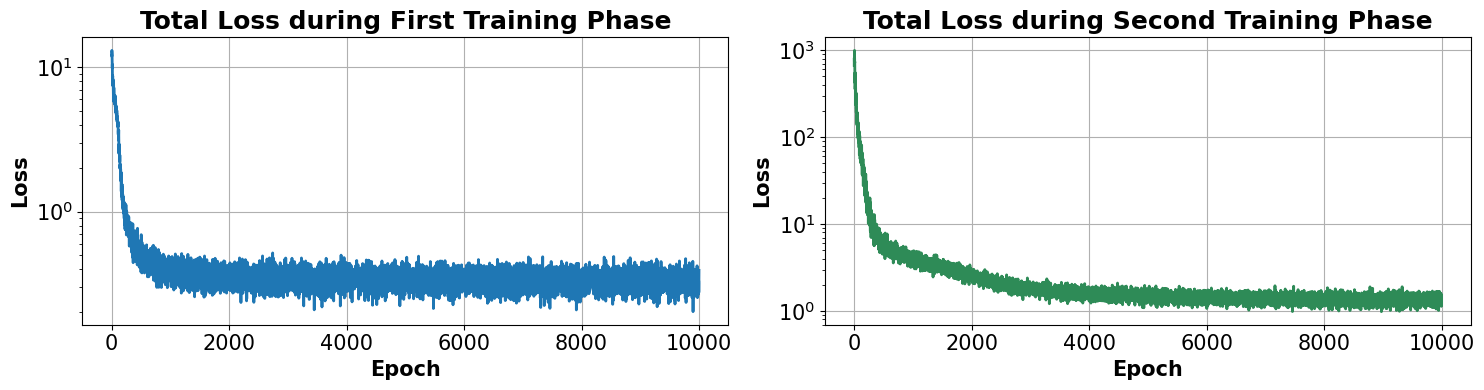

In [ ]:
## -------------- PLOT LOSS EVOLUTION FOR EACH TRAINING PHASE --------------- ##

# Visualize training loss across both optimization phases using a logarithmic scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# Phase 1 loss
ax1.plot(loss_history[:K], linewidth=2)
ax1.set_title("Total Loss during First Training Phase", fontsize=18, fontweight='bold')
ax1.set_xlabel("Epoch", fontsize=15, fontweight='bold')
ax1.set_ylabel("Loss", fontsize=15, fontweight='bold')
ax1.set_yscale('log')  # Set y-axis to log scale
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.grid(True)
# Phase 2 loss
ax2.plot(loss_history[K:], linewidth=2, color="seagreen")
ax2.set_title("Total Loss during Second Training Phase", fontsize=18, fontweight='bold')
ax2.set_xlabel("Epoch", fontsize=15, fontweight='bold')
ax2.set_ylabel("Loss", fontsize=15, fontweight='bold')
ax2.set_yscale('log')  # Set y-axis to log scale
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.grid(True)
plt.tight_layout()
plt.show()

## PINN-MPC Validation

### Functions

In [ ]:
## ----------- CLOSED-LOOP SINGLE TRAJECTORY SIMULATION (PINN-MPC) ---------- ##

def rollout(model, x0=0.2, ysp=1.0, u0=0.0, d0=0.0,
            K_VALVE=0.7, A=1.0, dt=0.01, Ts=1.0, noise=0.0,
            simulation_time=25.0, sp_change=5.0, d_step=30.0):
    """
    Simulates a single closed-loop trajectory of the nonlinear water tank system
    using the PINN-MPC controller.

    Args:
        model: Trained PINN-MPC controller.
        x0 (float): Initial tank level (m).
        ysp (float): Final setpoint after sp_change time (m).
        u0 (float): Initial inflow rate (m³/s).
        d0 (float): Constant disturbance inflow (m³/s).
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Cross-sectional area of the tank (m²).
        dt (float): Internal simulation time step (s).
        Ts (float): Controller sampling time (s).
        noise (float): Std dev of measurement noise on h (m).
        simulation_time (float): Total simulation duration (s).
        sp_change (float): Time when setpoint switches to h_set (s).
        d_step (float): Time when disturbance d0 is applied (s).

    Returns:
        t_hist (Tensor): Time history (s).
        y_hist (Tensor): Tank level history (m).
        u_hist (Tensor): Control input history (m³/s).
        hsp_hist (Tensor): Setpoint history (m).
        d_hist (Tensor): Disturbance history (m³/s).
    """
    query_step = Ts
    steps = int(simulation_time / query_step)

    y = torch.tensor([x0], device=DEVICE, dtype=torch.float)
    y_meas = y + torch.randn_like(y) * noise
    d0_base = torch.tensor([d0], device=DEVICE, dtype=torch.float)
    d0_curr = d0_base

    t_hist, y_hist, u_hist, ysp_hist, d_hist = [], [], [], [], []
    t_curr = 0.0

    u_prev = torch.tensor([K_VALVE * math.sqrt(max(x0, 0.0))],
                          device=DEVICE, dtype=torch.float)

    for _ in range(steps):
        ysp_tensor = torch.tensor(
            [x0 if t_curr < sp_change else ysp],
            device=DEVICE, dtype=torch.float)

        d0_curr = d0_base * (1.0 if t_curr >= d_step else 0.0)

        # Query the PINN-MPC controller
        y_pred_next, u_pred = model(torch.tensor([query_step], device=DEVICE),
                                    y_meas, u_prev, ysp_tensor, d0_curr)

        u_cmd = u_pred.item()

        # Simulate inner dynamics using fine steps
        y_curr = y.item()
        n_inner = int(query_step / dt)

        for _ in range(n_inner):
            dy = (u_cmd + d0_curr.item() - K_VALVE * math.sqrt(max(y_curr, 0.0))) / A
            y_curr = max(y_curr + dy * dt, 0.0)

            t_curr += dt
            t_hist.append(t_curr)
            y_hist.append(y_curr)
            u_hist.append(u_cmd)
            ysp_hist.append(ysp_tensor.item())
            d_hist.append(d0_curr.item())

        y = torch.tensor([y_curr], device=DEVICE, dtype=torch.float)
        y_meas = (y + torch.randn_like(y) * noise).clamp_min(0.0)
        u_prev = torch.tensor([u_cmd], device=DEVICE, dtype=torch.float)

    return (
        torch.tensor(t_hist, device=DEVICE),
        torch.tensor(y_hist, device=DEVICE),
        torch.tensor(u_hist, device=DEVICE),
        torch.tensor(ysp_hist, device=DEVICE),
        torch.tensor(d_hist, device=DEVICE))

## --- PARALLEL CLOSED-LOOP SIMULATION OVER MULTIPLE INSTANCES (PINN-MPC) --- ##

@torch.no_grad()
def rollout_batch(model, x0, ysp_target, u0, d0,
                  K_VALVE=0.7, A=1.0, dt=0.01, Ts=1.0, noise=0.0,
                  simulation_time=30.0, sp_change=5.0, d_step=30.0):
    """
    Simulates multiple single-tank systems in parallel using the PINN-MPC controller.

    Args:
        model: Trained PINN-MPC controller (SISO).
        x0 (Tensor): Initial tank levels [B] (m).
        ysp_target (Tensor): Target setpoints [B] (m).
        u0 (Tensor or None): Initial inflow rates [B] (m³/s).
        d0 (Tensor): Constant disturbances [B] (m³/s).
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt (float): Internal plant integration step (s).
        Ts (float): Controller sampling interval (s).
        noise (float): Std dev of measurement noise on x (m).
        simulation_time (float): Total duration (s).
        sp_change (float): Time when setpoint switches from x0 to ysp_target (s).
        d_step (float): Time when disturbance is applied (s).

    Returns:
        t_hist (Tensor): Time vector [N].
        X_hist (Tensor): Tank level trajectories [B, N] (m).
        U_hist (Tensor): Control input trajectories [B, N] (m³/s).
        YSP_hist (Tensor): Setpoint trajectories [B, N] (m).
        D_hist (Tensor): Disturbance trajectories [B, N] (m³/s).
    """
    # --- Initialization ---
    bs = x0.shape[0]
    n_query_steps = int(simulation_time / Ts)
    n_inner = int(Ts / dt)

    # Initialize current state, measurement, and previous input
    x_curr = x0.clone().to(DEVICE)
    x_meas = x_curr + torch.randn_like(x_curr) * noise
    # Default u_prev to steady-state u for the current state if not provided
    u_prev = u0.to(DEVICE) if u0 is not None else K_VALVE * torch.sqrt(x_curr.clamp(min=0.0))
    d0 = d0.to(DEVICE)

    # Initial setpoint is the initial state
    ysp_init = x0.clone().to(DEVICE)

    # History lists to store results from each fine step (dt)
    t_hist_list, X_hist_list, U_hist_list = [], [], []
    YSP_hist_list, D_hist_list = [], []
    t_curr_scalar = 0.0

    # --- Main Simulation Loop ---
    # This loop iterates at the *controller sampling rate* (Ts).
    for _ in range(n_query_steps):
        # --- Determine current setpoint and disturbance ---
        # Setpoint steps from initial state to target state at t=sp_change
        ysp_k = ysp_init if t_curr_scalar < sp_change else ysp_target.to(DEVICE)
        # Disturbance steps from 0 to d0 at t=d_step
        d_k = torch.zeros_like(d0) if t_curr_scalar < d_step else d0

        # --- Controller Query ---
        # Query the model for the state/input at the *next* control step (t=Ts).
        # This model's forward pass expects (B, 1) shaped inputs.
        t_query = torch.full((bs, 1), Ts, device=DEVICE)

        # model() returns (x_pred_next, u_pred_next)
        x_pred_next, u_pred = model(t_query, x_meas.unsqueeze(-1),
                                    u_prev.unsqueeze(-1), ysp_k.unsqueeze(-1),
                                    d_k.unsqueeze(-1))

        u_cmd = u_pred.squeeze(-1) # Use the predicted input
        x_inner = x_curr.clone()

        # --- Inner Plant Simulation (Euler Integration) ---
        # This loop iterates at the *plant simulation rate* (dt).
        for _ in range(n_inner):
            # Apply the single-tank dynamics
            dx = (u_cmd + d_k - K_VALVE * torch.sqrt(x_inner.clamp(min=0.0))) / A
            x_inner = (x_inner + dx * dt).clamp(min=0.0)
            t_curr_scalar += dt

            # --- Record History at every `dt` step ---
            t_hist_list.append(t_curr_scalar)
            X_hist_list.append(x_inner.cpu())
            U_hist_list.append(u_cmd.cpu())
            YSP_hist_list.append(ysp_k.cpu())
            D_hist_list.append(d_k.cpu())

        # --- Update State for Next Controller Query ---
        x_curr = x_inner.clone()
        x_meas = x_curr + torch.randn_like(x_curr) * noise
        u_prev = u_cmd.clone()

    # --- Format and Return Results ---
    # Convert history lists to stacked tensors
    t_hist = torch.tensor(t_hist_list, device=DEVICE)
    X_hist = torch.stack(X_hist_list, dim=1).to(DEVICE)   # (B, N)
    U_hist = torch.stack(U_hist_list, dim=1).to(DEVICE)   # (B, N)
    YSP_hist = torch.stack(YSP_hist_list, dim=1).to(DEVICE) # (B, N)
    D_hist = torch.stack(D_hist_list, dim=1).to(DEVICE)   # (B, N)

    return t_hist, X_hist, U_hist, YSP_hist, D_hist

## -------------------- EVALUATE PINN-MPC ON TEST CASES --------------------- ##

@torch.no_grad()
def evaluate_model_parallel_dist(model, x0_grid, ysp_grid, d0_grid,
                                 K_VALVE=0.7, A=1.0, dt=0.01, Ts=1.0,
                                 noise=0.0, simulation_time=25.0,
                                 sp_change=5.0, d_step=30.0) -> dict:
    """
    Evaluates the SISO model's closed-loop performance over a grid of scenarios.

    This function runs a parallel simulation (using `rollout_batch`) for
    a batch of initial conditions (x0), setpoints (ysp), and disturbances (d0).
    It then computes final steady-state error (SSE) metrics to quantify
    the controller's performance.

    Args:
        model: The trained PINN-MPC controller model (SISO).
        x0_grid (torch.Tensor): (B,) tensor of initial tank levels.
        ysp_grid (torch.Tensor): (B,) tensor of target setpoints.
        d0_grid (torch.Tensor): (B,) tensor of disturbance magnitudes.
        K_VALVE (float): Plant valve coefficient.
        A (float): Plant tank cross-sectional area.
        dt (float): Plant simulation time step.
        Ts (float): Controller sampling time.
        noise (float): Std dev of measurement noise.
        simulation_time (float): Total duration of the simulation.
        sp_change (float): Time to apply the new setpoint.
        d_step (float): Time to apply the disturbance.

    Returns:
        A dictionary containing various performance metrics.
    """
    # Set model to evaluation mode (disables dropout, etc.)
    model.eval()

    # --- Move inputs to model device ---
    device = next(model.parameters()).device
    x0         = x0_grid.to(device)
    ysp_target = ysp_grid.to(device) # Renamed for clarity in rollout_batch call
    d0         = d0_grid.to(device)

    # --- Run Parallel Rollout ---
    # Call the simulation function from siso_closed_loop_simulator.py
    # Pass u0=None to let the controller start from its default.
    t, X, U, _, _ = rollout_batch(
        model, x0, ysp_target, None, d0,
        K_VALVE=K_VALVE, A=A, dt=dt, Ts=Ts, noise=noise,
        simulation_time=simulation_time,
        sp_change=sp_change, d_step=d_step
    )

    # --- Calculate Final Error Metrics ---
    # To CPU for metrics
    X_cpu   = X.cpu()
    ysp_cpu = ysp_target.cpu()

    # Final signed error at end of sim
    final_sse = X_cpu[:, -1] - ysp_cpu      # (B,) signed error
    final_abs = final_sse.abs()

    # Percent error (handle division by small SPs)
    final_perc = final_sse / ysp_cpu.clamp(min=1e-6) * 100.0

    # --- Package and Return Results ---
    return {
        "final_sse":         final_sse,      # (B,) signed
        "final_sse_abs":     final_abs,      # (B,)
        "final_perc":        final_perc,     # (B,)
        "max_final_error":   float(final_abs.max().item()),
        "min_final_error":   float(final_abs.min().item()),
        "max_perc_error":    float(final_perc.abs().max().item()),
        "mean_abs_error":    float(final_abs.mean().item())
    }

In [ ]:
## ------------------ MULTI-CASE INFERENCE PINN-MPC PLOTS ------------------- ##

def evaluate_multi_case(model,
                        x0: float, u0: float,
                        ysp_list: Sequence[float], d0_list: Sequence[float],
                        K_VALVE: float = 0.7, A: float = 1.0,
                        dt: float = 0.01, Ts: float = 1.0,
                        noise: float = 0.0,
                        simulation_time: float = 20.0,
                        d_step: float = 30.0,
                        shift_time: float = 0.0,
                        plot_disturbance: bool = True,
                        ylimits = 'auto'):
    """
    Runs back-to-back rollouts (each of length `simulation_time`) for each
    (ysp, d0) pair in hsp_list and d0_list using the PINN-MPC controller.
    For each segment:
      • The set-point is updated immediately (sp_change = 0).
      • The disturbance is reset for each segment.
      • Only the final (h, u) from the segment are carried forward to the next.

    Args:
        model: Trained PINN-MPC controller.
        x0 (float): Initial tank level for the test (m).
        u0 (float): Initial control input for the test (m³/s).
        hsp_list (Sequence[float]): List of setpoints (m).
        d0_list (Sequence[float]): List of disturbance values (m³/s).
                                  Must be the same length as hsp_list.
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt (float): Fine simulation time step (s).
        Ts (float): PINN-MPC sampling time (s).
        noise (float): Std dev of measurement noise (m).
        simulation_time (float): Duration of each rollout segment (s).
        d_step (float): Time when the disturbance is activated (s).
        shift_time (float): Time (s) to shift the time axis for plotting.
        plot_disturbance (bool): Whether to plot the disturbance signal.
        ylimits: y-axis limits (tuple) for the plant output plot, or 'auto'.

    Returns:
        None. Generates full trajectory plot of h(t), u(t), and d(t) (if enabled).

    """
    # Ensure hsp_list and d0_list have the same length
    assert len(ysp_list) == len(d0_list), "hsp_list and d0_list must have the same length"

    # Storage for data from each segment
    t_segs, y_segs, u_segs, ysp_segs, d_segs = [], [], [], [], []

    # Process each segment sequentially
    for i, (ysp_seg, d0_seg) in enumerate(zip(ysp_list, d0_list)):
        # One rollout with immediate SP change (sp_change=0) and new disturbance d0_seg
        t, y_hist, u_hist, ysp_hist, d_hist = rollout(
            model, x0=x0, ysp=ysp_seg, u0=u0, d0=d0_seg,
            K_VALVE=K_VALVE, A=A, dt=dt, Ts=Ts, noise=noise,
            simulation_time=simulation_time, sp_change=0.0, d_step=d_step
        )

        # Convert tensors to NumPy arrays and offset the time axis for stacking
        t_np   = t.cpu().numpy() + i * simulation_time
        y_np   = y_hist.cpu().numpy()
        u_np   = u_hist.cpu().numpy()
        ysp_np = ysp_hist.cpu().numpy()
        d_np   = d_hist.cpu().numpy()

        # Omit duplicate join point (except for the first segment)
        if i > 0:
            t_np, y_np, u_np, ysp_np, d_np = (arr[1:] for arr in (t_np, y_np, u_np, ysp_np, d_np))

        # Collect segment data
        t_segs.append(t_np)
        y_segs.append(y_np)
        u_segs.append(u_np)
        ysp_segs.append(ysp_np)
        d_segs.append(d_np)

        # Carry forward only the final state values from this segment
        x0 = y_np[-1]
        u0 = u_np[-1]

    # Stitch segments together into full trajectories
    t_full   = np.concatenate(t_segs)
    y_full   = np.concatenate(y_segs)
    u_full   = np.concatenate(u_segs)
    ysp_full = np.concatenate(ysp_segs)
    d_full   = np.concatenate(d_segs)

    # Compute final error against the last setpoint
    final_err  = y_full[-1] - ysp_list[-1]
    final_perc = (final_err / ysp_list[-1] * 100) if ysp_list[-1] != 0 else 0.0
    print(f"--- Final error: {final_err:.4f} m ({final_perc:.2f} %) ---")

    # Apply time shift if requested
    if shift_time > 0:
        mask     = t_full >= shift_time
        t_plot   = t_full[mask] - shift_time
        y_plot   = y_full[mask]
        ysp_plot = ysp_full[mask]
        u_plot   = u_full[mask]
        d_plot   = d_full[mask]
    else:
        t_plot, y_plot, ysp_plot, u_plot, d_plot = t_full, y_full, ysp_full, u_full, d_full

    # Controlled Output
    c_y1_pinn = 'steelblue'
    c_y1_sp   = 'black'
    # Control Signals
    c_u1_pinn = 'mediumpurple' # '#8b6ab7'
    # Disturbance Profile
    c_d = 'darkcyan'   # Cyan

    # Set up the plot dimensions
    n_rows = 3 if plot_disturbance else 2
    fig, axes = plt.subplots(n_rows, 1, figsize=(15.0, 3.5 * n_rows), sharex=True)

    if plot_disturbance:
        ax_h, ax_u, ax_d = axes
    else:
        ax_h, ax_u = axes

    # --- h(t): Plant Output vs Setpoint ---
    ax_h.plot(t_plot, y_plot, color=c_y1_pinn, linewidth=4.5, label=r"$y(t)$")
    ax_h.plot(t_plot, ysp_plot, '--', color=c_y1_sp, linewidth=4.5, label=r"$y_{\mathrm{sp}}$") #red
    ax_h.set_ylabel("Tank Level (m)", fontsize=20)
    ax_h.set_xlim([t_plot[0], t_plot[-1]])
    ax_h.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_h.tick_params(labelsize=18)
    ax_h.legend(loc='best', fontsize=20)
    ax_h.set_title("Controlled Output", fontsize=22, fontweight='bold')
    ax_h.yaxis.set_major_locator(MultipleLocator(0.3))
    if ylimits != 'auto':
        ax_h.set_ylim(ylimits)

    # --- u(t): Control Signal ---
    ax_u.plot(t_plot, u_plot, color=c_u1_pinn, linewidth=4.5, label=r"$u(t)$")
    ax_u.set_ylabel(r"Control Flow ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
    ax_u.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_u.legend(loc='best', fontsize=20)
    ax_u.tick_params(labelsize=18)
    ax_u.set_title("Control Signal", fontsize=22, fontweight='bold')
    ax_u.yaxis.set_major_locator(MultipleLocator(0.2))
    ax_u.set_ylim([0, 1])

    # --- d(t): Disturbance Profile ---
    if plot_disturbance:
        ax_d.plot(t_plot, d_plot, '--', color=c_d, linewidth=4.5, label=r"$d(t)$")
        ax_d.set_ylabel(r"Disturbance ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
        ax_d.set_xlabel("Time (s)", fontsize=20)
        ax_d.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax_d.legend(loc='best', fontsize=20)
        ax_d.tick_params(labelsize=18)
        ax_d.set_title("Disturbance Profile", fontsize=22, fontweight='bold')
    else:
        ax_u.set_xlabel("Time (s)", fontsize=20)

    plt.tight_layout(pad=1.2)
    plt.savefig("control_results.eps", format='eps', dpi=300, bbox_inches='tight')
    plt.show()

### Run

In [ ]:
## ------------ VALIDATE PINN-MPC ON SET-POINT TRACKING SCENARIOS ----------- ##

# Load test samples
data = torch.load('siso_test_samples.pt', map_location="cpu")  # always portable
x0_sp  = data["x0_sp"].to(DEVICE, non_blocking=True)
ysp_sp = data["ysp_sp"].to(DEVICE, non_blocking=True)
d0_sp  = data["d0_sp"].to(DEVICE, non_blocking=True)
x0_dr  = data["x0_dr"].to(DEVICE, non_blocking=True)
ysp_dr = data["ysp_dr"].to(DEVICE, non_blocking=True)
d0_dr  = data["d0_dr"].to(DEVICE, non_blocking=True)

# SP TRACKING
metrics_sp = evaluate_model_parallel_dist(
    model, x0_sp, ysp_sp, d0_sp,
    dt=0.01, Ts=1.0, sp_change=0.0, d_step=0.0,
    simulation_time=30.0)

# Metrics
print(f"[SP] Mean final |error| : {metrics_sp['mean_abs_error']:.4f} m")
print(f"[SP] Max final |error|  : {metrics_sp['max_final_error']:.4f} m")
print(f"[SP] Min final |error|  : {metrics_sp['min_final_error']:.4f} m")
print("---------------------------------------------------------------------")

# DR
metrics_dist = evaluate_model_parallel_dist(
    model, x0_dr, ysp_dr, d0_dr,
    dt=0.01, Ts=1.0, sp_change=0.0, d_step=0.0,
    simulation_time=30.0)

print(f"[DR] Mean final |error| : {metrics_dist['mean_abs_error']:.4f} m")
print(f"[DR] Max final |error|  : {metrics_dist['max_final_error']:.4f} m")
print(f"[DR] Min final |error|  : {metrics_dist['min_final_error']:.4f} m")
print("---------------------------------------------------------------------")

[SP] Mean final |error| : 0.0161 m
[SP] Max final |error|  : 0.0322 m
[SP] Min final |error|  : 0.0000 m
---------------------------------------------------------------------
[DR] Mean final |error| : 0.0129 m
[DR] Max final |error|  : 0.0453 m
[DR] Min final |error|  : 0.0000 m
---------------------------------------------------------------------


## Multi-Case Closed-Loop Plots

### Function

In [ ]:
## ------------------ MULTI-CASE INFERENCE PINN-MPC PLOTS ------------------- ##

@torch.no_grad()
def evaluate_multi_case(model,
                        x0: float, u0: float,
                        ysp_list: Sequence[float], d0_list: Sequence[float],
                        K_VALVE: float = 0.7, A: float = 1.0,
                        dt_inner: float = None,     # Plant sim step. If None -> Ts/substeps
                        Ts: float = 1.0,
                        substeps: int = 20,         # Inner steps per Ts when dt_inner is None
                        integrator: str = "rk2",    # "rk2" or "euler"
                        noise: float = 0.0,
                        simulation_time: float = 20.0, # Duration *per episode*
                        d_step: float = 30.0,       # Time *within each episode* to apply disturbance
                        shift_time: float = 0.0,
                        plot_disturbance: bool = True,
                        ylimits='auto',
                        store_stride: int = 1):
    """
    Runs back-to-back rollouts (each of length `simulation_time`) for each
    (ysp, d0) pair in ysp_list and d0_list using the PINN-MPC controller.
    For each segment:
      • The set-point is updated immediately (sp_change = 0).
      • The disturbance is reset for each segment.
      • Only the final (x, u) from the segment are carried forward to the next.

    Args:
        model: Trained PINN-MPC controller.
        x0 (float): Initial tank level for the test (m).
        u0 (float): Initial control input for the test (m³/s).
        ysp_list (Sequence[float]): List of setpoints (m).
        d0_list (Sequence[float]): List of disturbance values (m³/s).
                                   Must be the same length as ysp_list.
        K_VALVE (float): Valve coefficient (m².⁵/s).
        A (float): Tank cross-sectional area (m²).
        dt_inner (float): Fine simulation time step (s).
        Ts (float): PINN-MPC sampling time (s).
        substeps (int): Inner steps per Ts when dt_inner is None.
        integrator (str): 'rk2' or 'euler' for the NumPy plant sim.
        noise (float): Std dev of measurement noise (m).
        simulation_time (float): Duration of each rollout segment (s).
        d_step (float): Time when the disturbance is activated (s).
        shift_time (float): Time (s) to shift the time axis for plotting.
        plot_disturbance (bool): Whether to plot the disturbance signal.
        ylimits: y-axis limits (tuple) for the plant output plot, or 'auto'.
    """

    # --- 1. Setup: Model, Device, and Physics Parameters ---
    assert len(ysp_list) == len(d0_list), "ysp_list and d0_list must have the same length"

    DEVICE = next(model.parameters()).device
    DTYPE = next(model.parameters()).dtype
    model.eval()

    # Get physics parameters (can be from args or model)
    # Using args here for flexibility, but could read from model
    eps = 1e-8

    # --- 2. Internal NumPy-based Plant Simulator ---
    def rhs(x_arr, u_arr, d_arr):
        """NumPy RHS function for the SISO plant dynamics."""
        x = x_arr[0]
        u = u_arr[0]
        d = d_arr[0]
        s = np.sqrt(max(x, 0.0) + eps)
        dx = (u + d - K_VALVE * s) / A
        return np.array([dx], dtype=np.float64)

    def step(x, u, d, dt):
        """A single integration step for the plant."""
        if integrator.lower() == "rk2":
            # 2nd-order Runge-Kutta (midpoint method)
            k_1 = rhs(x, u, d)
            x_m = np.maximum(x + 0.5 * dt * k_1, 0.0)
            k_2 = rhs(x_m, u, d)
            return np.maximum(x + dt * k_2, 0.0)
        else:
            # Forward Euler
            return np.maximum(x + dt * rhs(x, u, d), 0.0)

    # --- 3. Simulation Loop Setup ---
    if dt_inner is None:
        dt_inner = Ts / substeps
    n_inner = max(1, int(round(Ts / dt_inner)))
    dt_inner = Ts / n_inner  # Recalculate exact dt_inner

    # Storage for stitched episodes
    T_all, X_all, U_all, YSP_all, D_all = [], [], [], [], []
    t_global = 0.0  # for stitched plots only

    # Prepare noise tensor (1x1) once
    noise_std_1x1 = torch.full((1, 1), float(noise), device=DEVICE, dtype=DTYPE)

    with torch.inference_mode():
        # Initialize state and input for the first episode
        x_prev = np.array([x0], dtype=np.float64)
        u_prev = np.array([u0], dtype=np.float64)

        # --- 4. Loop Over Scenarios (Episodes) ---
        for seg_idx, (ysp_val, d0_val) in enumerate(zip(ysp_list, d0_list)):
            steps = int(round(simulation_time / Ts))
            N_tot = steps * n_inner

            # Preallocate NumPy arrays for this episode's history
            t_seg   = np.empty(N_tot, dtype=np.float64)
            x_seg   = np.empty((N_tot, 1), dtype=np.float64)
            u_seg   = np.empty((N_tot, 1), dtype=np.float64)
            ysp_seg = np.empty((N_tot, 1), dtype=np.float64)
            d_seg   = np.empty((N_tot, 1), dtype=np.float64)

            x = x_prev.copy()
            u_cmd = u_prev.copy()
            d_vec = np.array([d0_val], dtype=np.float64)

            write_i = 0
            t_local = 0.0  # Per-episode clock (resets each episode)

            # --- 4a. Main Control Loop (per Ts) ---
            for _ in range(steps):
                # Disturbance is OFF until t_local >= d_step (per episode)
                d_now = np.array([0.0], dtype=np.float64) if t_local < d_step else d_vec
                ysp_now = np.array([ysp_val], dtype=np.float64)

                # --- 4b. Controller Query (once per Ts) ---
                # This model expects 1D (batch) tensors, not (B,1)
                t_query_t = torch.tensor([Ts], device=DEVICE, dtype=DTYPE)
                x_meas_t = torch.tensor(x, device=DEVICE, dtype=DTYPE) # (1,)

                # Add per-state Gaussian noise
                if float(noise_std_1x1.abs().sum().item()) > 0.0:
                    x_meas_t = (x_meas_t + torch.randn_like(x_meas_t) * noise_std_1x1[0]).clamp_min(0.0)

                u_prev_t = torch.tensor(u_cmd, device=DEVICE, dtype=DTYPE) # (1,)
                ysp_t    = torch.tensor(ysp_now, device=DEVICE, dtype=DTYPE) # (1,)
                d_t      = torch.tensor(d_now, device=DEVICE, dtype=DTYPE)   # (1,)

                # Get action from PINN-MPC (SISO model forward pass)
                _, u_pred = model(t_query_t, x_meas_t, u_prev_t, ysp_t, d_t)
                u_cmd = u_pred.view(-1).detach().cpu().numpy().astype(np.float64) # (1,)

                # --- 4c. Inner Plant Simulation (per dt_inner) ---
                for _ in range(n_inner):
                    x = step(x, u_cmd, d_now, dt_inner)
                    t_global += dt_inner
                    t_local  += dt_inner

                    # Store history at the fine time step
                    if write_i < N_tot:
                        t_seg[write_i]   = t_global
                        x_seg[write_i]   = x
                        u_seg[write_i]   = u_cmd
                        ysp_seg[write_i] = ysp_now
                        d_seg[write_i]   = d_now
                        write_i += 1

            # Drop duplicate join sample when stitching
            if seg_idx > 0:
                t_seg, x_seg, u_seg, ysp_seg, d_seg = (
                    t_seg[1:], x_seg[1:], u_seg[1:], ysp_seg[1:], d_seg[1:]
                )

            # Optional downsampling
            if store_stride > 1:
                sl = slice(None, None, store_stride)
                t_seg, x_seg, u_seg, ysp_seg, d_seg = (
                    t_seg[sl], x_seg[sl], u_seg[sl], ysp_seg[sl], d_seg[sl]
                )

            # Append this episode's history to the full list
            T_all.append(t_seg); X_all.append(x_seg); U_all.append(u_seg)
            YSP_all.append(ysp_seg); D_all.append(d_seg)

            # Carry final state to next episode
            x_prev = x_seg[-1].copy()
            u_prev = u_seg[-1].copy()

    # --- 5. Stitch All Episodes Together ---
    t_full   = np.concatenate(T_all, axis=0)
    x_full   = np.concatenate(X_all, axis=0).squeeze() # (M, 1) -> (M,)
    u_full   = np.concatenate(U_all, axis=0).squeeze() # (M, 1) -> (M,)
    ysp_full = np.concatenate(YSP_all, axis=0).squeeze() # (M, 1) -> (M,)
    d_full   = np.concatenate(D_all, axis=0).squeeze() # (M, 1) -> (M,)

    # --- 6. Final Error Calculation ---
    final_err  = x_full[-1] - ysp_list[-1]
    final_perc = (final_err / ysp_list[-1] * 100) if ysp_list[-1] != 0 else 0.0
    print(f"--- Final error: {final_err:.4f} m ({final_perc:.2f} %) ---")

    # --- 7. Time Shift for Plotting (Optional) ---
    if shift_time > 0:
        mask     = t_full >= shift_time
        t_plot   = t_full[mask] - shift_time
        x_plot   = x_full[mask]
        ysp_plot = ysp_full[mask]
        u_plot   = u_full[mask]
        d_plot   = d_full[mask]
    else:
        t_plot, x_plot, ysp_plot, u_plot, d_plot = t_full, x_full, ysp_full, u_full, d_full

    # --- 8. Plotting ---
    # Define colors
    c_y1_pinn = 'steelblue'
    c_y1_sp   = 'black'
    c_u1_pinn = 'mediumpurple'
    c_d       = 'darkcyan'

    # Create figure layout
    n_rows = 3 if plot_disturbance else 2
    fig, axes = plt.subplots(n_rows, 1, figsize=(15.0, 3.5 * n_rows), sharex=True)

    if plot_disturbance:
        ax_x, ax_u, ax_d = axes
    else:
        ax_x, ax_u = axes
        ax_u.set_xlabel("Time (s)", fontsize=20)

    # --- Plot 1: x(t): Plant Output vs Setpoint ---
    ax_x.plot(t_plot, x_plot, color=c_y1_pinn, linewidth=4.5, label=r"$x(t)$")
    ax_x.plot(t_plot, ysp_plot, '--', color=c_y1_sp, linewidth=4.5, label=r"$y_{\mathrm{sp}}$")
    ax_x.set_ylabel("Tank Level (m)", fontsize=20)
    ax_x.set_xlim([t_plot[0], t_plot[-1]])
    ax_x.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_x.tick_params(labelsize=18)
    ax_x.legend(loc='best', fontsize=20)
    ax_x.set_title("Controlled Output", fontsize=22, fontweight='bold')
    ax_x.yaxis.set_major_locator(MultipleLocator(0.3))
    if ylimits != 'auto':
        ax_x.set_ylim(ylimits)

    # --- Plot 2: u(t): Control Signal ---
    ax_u.plot(t_plot, u_plot, color=c_u1_pinn, linewidth=4.5, label=r"$u(t)$")
    ax_u.set_ylabel(r"Control Flow ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
    ax_u.grid(True, which='both', linestyle=':', linewidth=0.5)
    ax_u.legend(loc='best', fontsize=20)
    ax_u.tick_params(labelsize=18)
    ax_u.set_title("Control Signal", fontsize=22, fontweight='bold')
    ax_u.yaxis.set_major_locator(MultipleLocator(0.2))
    ax_u.set_ylim([0, 1])

    # --- Plot 3: d(t): Disturbance Profile ---
    if plot_disturbance:
        ax_d.plot(t_plot, d_plot, '--', color=c_d, linewidth=4.5, label=r"$d(t)$")
        ax_d.set_ylabel(r"Disturbance ($\mathrm{m}^3/\mathrm{s}$)", fontsize=20)
        ax_d.set_xlabel("Time (s)", fontsize=20)
        ax_d.grid(True, which='both', linestyle=':', linewidth=0.5)
        ax_d.legend(loc='best', fontsize=20)
        ax_d.tick_params(labelsize=18)
        ax_d.set_title("Disturbance Profile", fontsize=22, fontweight='bold')

    # --- Final Touches ---
    plt.tight_layout(pad=1.2)
    plt.show()

    return t_full, x_full, u_full, ysp_full, d_full

### Run

--- Final error: -0.0094 m (-0.52 %) ---


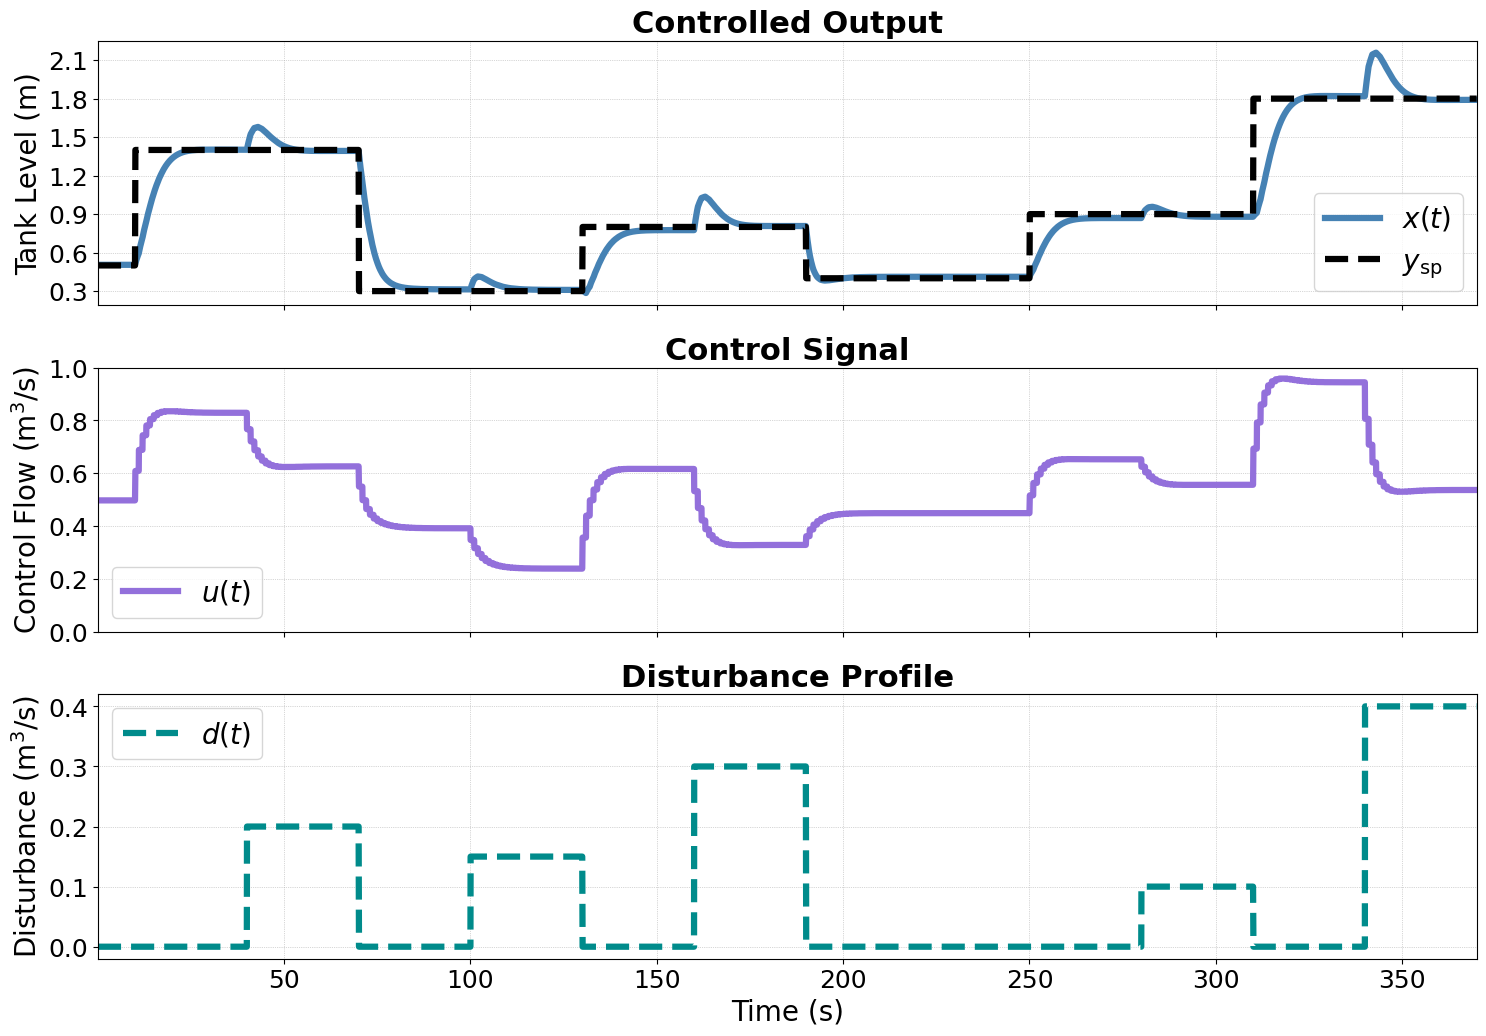

(array([5.0000e-02, 1.0000e-01, 1.5000e-01, ..., 4.1990e+02, 4.1995e+02,
        4.2000e+02]),
 array([0.4830955 , 0.46661133, 0.45054412, ..., 1.7905553 , 1.79055744,
        1.79055955]),
 array([0.1526302 , 0.1526302 , 0.1526302 , ..., 0.53672457, 0.53672457,
        0.53672457]),
 array([0.5, 0.5, 0.5, ..., 1.8, 1.8, 1.8]),
 array([0. , 0. , 0. , ..., 0.4, 0.4, 0.4]))

In [ ]:
## ----------- PLOT CLOSED-LOOP RESPONSE ACROSS MULTIPLE SCENARIOS ---------- ##

# Define sequences of set-points and disturbances
ysp_list = [0.5, 1.4, 0.3, 0.8, 0.4, 0.9, 1.8]     # Desired levels [m]
d0_list  = [0.0, 0.2, 0.15, 0.3, 0.0, 0.1, 0.4]    # Step disturbances [m³/s]

# Simulate multiple back-to-back scenarios and plot response
evaluate_multi_case(
    model,
    x0=0.5, u0=0.0,
    ysp_list=ysp_list,
    d0_list=d0_list,
    simulation_time=60.0,
    d_step=30.0,
    shift_time=50.0,   # Focus view on final segment
    noise=0.0
)